In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import collections

In [2]:
# coordinates = np.load('/content/drive/MyDrive/SSIP/x_y_cord.npy')
# ds = coordinates

In [3]:
# Normalized by Ivan
# regular_nor_coordinates = np.load('/content/drive/MyDrive/SSIP/track_37min_new/regular_37min_NOR.npy')
regular_raw_coordinates = np.load('/content/drive/MyDrive/SSIP/track_37min_new/split_nojam_37min_RAW.npy')
ds = regular_raw_coordinates

In [4]:
def normalize(ds):
  min_val = tf.reduce_min(ds)
  max_val = tf.reduce_max(ds)

  ds = (ds - min_val) / (max_val - min_val)
  ds = tf.cast(ds, tf.float32)
  print('Min, Max: ', tf.reduce_min(ds), tf.reduce_max(ds))
  
  return ds

In [5]:
def shape_correction(ds):
  ds = tf.cast(ds, tf.float32)
  ds = tf.expand_dims(ds, 1)
  ds = tf.reshape(ds, shape=(ds.shape[0], ds.shape[2], ds.shape[3], ds.shape[1]))
  print("After shape correction: ", ds.shape)
  return ds

In [6]:
from keras.layers import Input, Conv2D, Conv1D, MaxPool1D, Conv2DTranspose, Flatten, Dense, Reshape, InputLayer, Lambda
from keras.models import Model, Sequential

In [7]:
print(ds.min())
print(ds.max())
print(ds.mean())

16.5
1267.5
525.0992619355306


In [8]:
ds = normalize(ds)
ds = shape_correction(ds)
ds = tf.random.shuffle(ds, seed=42)

x_train = ds[300:]
x_val = ds[:300]

Min, Max:  tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
After shape correction:  (2325, 2, 96, 1)


In [9]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices(x_val)
val_dataset = val_dataset.batch(1) # no batches for the validation

In [10]:
# print(train_dataset)

# for i in train_dataset.take(1):
#   print(i.shape)

In [11]:
train_steps_per_epoch = math.ceil(x_train.shape[0] / batch_size)
val_steps_per_epoch   = math.ceil(x_val.shape[0] / 1) # no batches for the validation

# Create an VAE

In [12]:
# Build the model
shape = ds.shape
inputs = Input(shape[1:])
latent_dim = 8
dense_space = 12

# Encoding Layers:
def simple_encoder(filters_origin=32, latent_dim=latent_dim, final_activation=None):
  return Sequential([
                     InputLayer(shape[1:]),
                     Conv2D(filters=filters_origin,  kernel_size=(2, 6), strides=(2, 2), padding='same', activation='relu'),
                     Conv2D(filters=filters_origin/2,  kernel_size=(2, 6), strides=(1, 2), padding='same', activation='relu'),
                     Conv2D(filters=filters_origin/4,  kernel_size=(1, 6), strides=(1, 2), padding='same', activation='relu'),
                     Flatten(),
                     Dense(latent_dim, activation=final_activation)
  ])

def simple_decoder(latent_dim=latent_dim, filters_origin=32):
  return Sequential([
                     InputLayer((latent_dim,)),
                     Dense(latent_dim*dense_space, activation='relu'),
                     Reshape((1, dense_space, latent_dim)),
                     Conv2DTranspose(filters=filters_origin/2,  kernel_size=(1, 6), strides=(1, 2), padding='same', activation='relu'),
                     Conv2DTranspose(filters=filters_origin,  kernel_size=(2, 6), strides=(1, 2), padding='same', activation='relu'),
                     Conv2DTranspose(filters=1,  kernel_size=(2, 6), strides=(2, 2), padding='same', activation='relu')

  ])

In [13]:
# Encoder
vae_encoder = simple_encoder(latent_dim=latent_dim*2, filters_origin=32)
vae_encoder.summary()
# Decoder
vae_decoder = simple_decoder(latent_dim, filters_origin=32)
vae_decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 48, 32)         416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 24, 16)         6160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 12, 8)          776       
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1552      
Total params: 8,904
Trainable params: 8,904
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Out

# Reparameterization Trick and Complete VAE

In [14]:
def reparameterize_and_sample(z_mean, z_log_var):
    """
    Sample a vector from the random normal distribution, using the
    reparameterization trick.
    Note: `log(var)` (with `var` the distribution variance) is asked as
          parameter rather than `var` or `sqrt(var)` (standard deviation)
          to simplify the network's task. Indeed, if we do not constrain the
          encoder, it can by default output negative or positive values; but
          the variance should be strictly positive. Therefore, we simply consider
          the encoder's output as being the variance on a log scale, c.f.
          var = exp(log(var)) always > 0.
    :param z_mean: 
    :param z_log_var: 
    :return: 
    """
    epsilon = tf.random.normal(shape=tf.shape(z_mean), mean=0, stddev=1)
    z = z_mean + epsilon * tf.math.exp(z_log_var)
    return z

MeanAndLogvarSliceLayer = Lambda(
    lambda args: [tf.reshape(args[..., :latent_dim], (-1, latent_dim)),
                   tf.reshape(args[..., latent_dim:], (-1, latent_dim))],
    name='z_mean-z_logvar_slicer')
ReparameterizationLayer = Lambda(
    lambda args: reparameterize_and_sample(args[0], 
                                           args[1]),
    name='z_sampler')

In [15]:
inputs = Input(shape[1:], name='input_trajectories')
encoder_outputs = vae_encoder(inputs)
z_mean, z_log_sigma = MeanAndLogvarSliceLayer(encoder_outputs)
z = ReparameterizationLayer([z_mean, z_log_sigma])
output = vae_decoder(z)

vae_model = Model(inputs, [output, encoder_outputs])
vae_model.summary(positions=[.35, .65, .75, 1.])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                      Output Shape                 Param #   Connected to             
input_trajectories (InputLayer)   [(None, 2, 96, 1)]           0                                  
__________________________________________________________________________________________________
sequential (Sequential)           (None, 16)                   8904      input_trajectories[0][0] 
__________________________________________________________________________________________________
z_mean-z_logvar_slicer (Lambda)   [(None, 8), (None, 8)]       0         sequential[0][0]         
__________________________________________________________________________________________________
z_sampler (Lambda)                (None, 8)                    0         z_mean-z_logvar_slicer[0]
                                                                         z_mean-z_logvar_slice

# Loss Functions

In [16]:
import tensorflow.keras.backend as K

def KL_loss(y_true, y_pred):
    z_mean, z_log_sigma = MeanAndLogvarSliceLayer(y_pred)
    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return kl_loss


"""SHOULD I SUM OR MEAN the MSE"""
def mse_loss(y_true, y_pred):
    mse = tf.losses.mse(y_true, y_pred)
    mse = K.sum(mse, axis=[i for i in range(1, len(mse.shape))])
    return mse

In [17]:
vae_model.compile(optimizer='adam', loss=[mse_loss, KL_loss])

We adapt our input pipelines so that the ground-truths for the losses are provided. For the MSE loss, the original image is copied as target. For the KL loss, no ground-truths are actually needed to compute this loss (as it only evaluates the correctness of the means and standard deviations generated by the encoder). However, Keras requires that a ground-truth object is provided for each loss. Therefore, to circumvent this limitation, we simply pass a dummy tensor to Keras as ground-truth for the second loss.

In [18]:
none_tensor = tf.constant(0)
train_dataset_with_gt = train_dataset.map(lambda x: (x, (x, none_tensor)))
val_dataset_with_gt = val_dataset.map(lambda x: (x, (x, none_tensor)))

In [19]:
model_name = 'vae_angel_2'
import os
model_dir = model_dir = os.path.join('/content/drive/MyDrive/SSIP', model_name)


# # There is a problem with this callback
# # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1):
# metrics_to_print = collections.OrderedDict([("loss", "loss"), ("val-loss", "val_loss"),
#                                             ("KL", "encoder_loss"), ("val-KL", "val_encoder_loss"),
#                                             ("MSE", "decoder_loss"), ("val-MSE", "val_decoder_loss")])

# callback_simple_log = SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=2)


callbacks = [
             
    # Callback to interrupt the training if the loss stops decreasing:    
    # tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', mode='min',
    #                                  restore_best_weights=True),
             
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model  specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=1),

        
    # # Callback to print compacted metrics at the end of each epoch:
    # callback_simple_log
        
]

In [20]:
num_epochs = 100

history = vae_model.fit(
    train_dataset_with_gt, epochs=num_epochs, steps_per_epoch=train_steps_per_epoch, 
    validation_data=val_dataset_with_gt, validation_steps=val_steps_per_epoch,
    verbose=2, callbacks=callbacks
    )

Epoch 1/100
64/64 - 70s - loss: 12.2595 - sequential_1_loss: 12.1357 - sequential_loss: 0.1237 - val_loss: 4.2601 - val_sequential_1_loss: 4.2085 - val_sequential_loss: 0.0515
Epoch 2/100
64/64 - 1s - loss: 3.1062 - sequential_1_loss: 2.8177 - sequential_loss: 0.2884 - val_loss: 2.8055 - val_sequential_1_loss: 2.3862 - val_sequential_loss: 0.4193
Epoch 3/100
64/64 - 1s - loss: 2.5084 - sequential_1_loss: 2.1688 - sequential_loss: 0.3396 - val_loss: 2.5852 - val_sequential_1_loss: 2.1464 - val_sequential_loss: 0.4388
Epoch 4/100
64/64 - 1s - loss: 2.2080 - sequential_1_loss: 1.8380 - sequential_loss: 0.3699 - val_loss: 2.2695 - val_sequential_1_loss: 1.8127 - val_sequential_loss: 0.4568
Epoch 5/100
64/64 - 2s - loss: 2.0117 - sequential_1_loss: 1.6397 - sequential_loss: 0.3720 - val_loss: 2.2118 - val_sequential_1_loss: 1.7884 - val_sequential_loss: 0.4234
Epoch 6/100
64/64 - 1s - loss: 1.9436 - sequential_1_loss: 1.5750 - sequential_loss: 0.3686 - val_loss: 2.0517 - val_sequential_1_lo

# Evaluation

In [30]:
history.history.keys()

dict_keys(['loss', 'sequential_1_loss', 'sequential_loss', 'val_loss', 'val_sequential_1_loss', 'val_sequential_loss'])

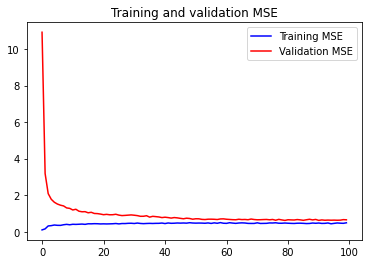

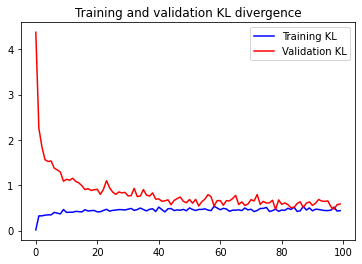

<Figure size 432x288 with 0 Axes>

In [31]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------

MSE_loss      = history.history['sequential_loss']
MSE_val_loss  = history.history['sequential_1_loss' ]
KL_loss     = history.history['val_sequential_loss' ]
KL_val_loss = history.history['val_sequential_1_loss' ]

epochs   = range(len(KL_loss)) # Get number of epoch

#------------------------------------------------
# Plot training and validation MSE per epoch
#------------------------------------------------
plt.plot  ( epochs,     MSE_loss, 'b', label='Training MSE' )
plt.plot  ( epochs, MSE_val_loss , 'r', label='Validation MSE' )
plt.title ('Training and validation MSE')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation KL per epoch
#------------------------------------------------
plt.plot  ( epochs,     KL_loss, 'b', label='Training KL' )
plt.plot  ( epochs, KL_val_loss , 'r', label='Validation KL' )
plt.title ('Training and validation KL divergence')
plt.legend()
plt.figure()

# #------------------------------------------------
# # Plot training and validation loss per epoch
# #------------------------------------------------
# plt.plot  ( epochs,     loss , 'bo', label='Training Loss' )
# plt.plot  ( epochs, val_loss , 'ro', label='Validation Loss' )
# plt.title ('Training and validation loss'   )
# plt.legend()

plt.show()

# Test New Data

## Import, Prepare, Predict

### ANGELS INPUT

In [21]:
# Test Anomalies
# anom_wrongway_coordinates = np.load('/content/drive/MyDrive/SSIP/track_37min_new/anomaly_wrongexit_37min_NOR.npy')

anom_pause_coordinates_raw = np.load('/content/drive/MyDrive/SSIP/track_37min_new/anomaly_pause_37min_RAW.npy')
anom_speedup_coordinates_raw = np.load('/content/drive/MyDrive/SSIP/track_37min_new/anomaly_speedup_37min_RAW.npy')
anom_timeflip_coordinates_raw = np.load('/content/drive/MyDrive/SSIP/track_37min_new/anomaly_timeflip_37min_RAW.npy')
anom_wrongentry_coordinates_raw = np.load('/content/drive/MyDrive/SSIP/track_37min_new/anomaly_wrongentry_37min_RAW.npy'),
anom_wrongexit_coordinates_raw = np.load('/content/drive/MyDrive/SSIP/track_37min_new/anomaly_wrongexit_37min_RAW.npy'),
anom_tree_min_raw = np.load('/content/drive/MyDrive/SSIP/track_37min_new/split_trafficjam_37min_RAW.npy')


list_abnormalities = [anom_pause_coordinates_raw, anom_speedup_coordinates_raw, 
                      anom_timeflip_coordinates_raw, anom_wrongentry_coordinates_raw,
                      anom_wrongexit_coordinates_raw]

In [22]:
# anom_pause_coordinates_raw
anom_pause_coordinates_raw = normalize(anom_pause_coordinates_raw)
anom_pause_coordinates_raw = shape_correction(anom_pause_coordinates_raw)
pred_pause = vae_model(anom_pause_coordinates_raw)
mse_pause = mse_loss(anom_pause_coordinates_raw, pred_pause[0])
np.save('/content/drive/MyDrive/SSIP/VAE_angel_2_output/mse_angel_pause', mse_pause.numpy())


Min, Max:  tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
After shape correction:  (50, 2, 96, 1)


In [23]:
# anom_pause_coordinates_raw
anom_speedup_coordinates_raw = normalize(anom_speedup_coordinates_raw)
anom_speedup_coordinates_raw = shape_correction(anom_speedup_coordinates_raw)
pred_speedup = vae_model(anom_speedup_coordinates_raw)
mse_speedup = mse_loss(anom_speedup_coordinates_raw, pred_speedup[0])
np.save('/content/drive/MyDrive/SSIP/VAE_angel_2_output/mse_angel_speedup', mse_speedup.numpy())

Min, Max:  tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
After shape correction:  (50, 2, 96, 1)


In [24]:
# anom_timeflip_coordinates_raw
anom_timeflip_coordinates_raw = normalize(anom_timeflip_coordinates_raw)
anom_timeflip_coordinates_raw = shape_correction(anom_timeflip_coordinates_raw)
pred_timeflip = vae_model(anom_timeflip_coordinates_raw)
mse_timeflip = mse_loss(anom_timeflip_coordinates_raw, pred_timeflip[0])
np.save('/content/drive/MyDrive/SSIP/VAE_angel_2_output/mse_angel_timeflip', mse_timeflip.numpy())

Min, Max:  tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
After shape correction:  (50, 2, 96, 1)


In [25]:
# anom_wrongentry_coordinates_raw
anom_wrongentry_coordinates_raw = normalize(anom_wrongentry_coordinates_raw[0])
anom_wrongentry_coordinates_raw = shape_correction(anom_wrongentry_coordinates_raw)
pred_wrongentry = vae_model(anom_wrongentry_coordinates_raw)
mse_wrongentry = mse_loss(anom_wrongentry_coordinates_raw, pred_wrongentry[0])
np.save('/content/drive/MyDrive/SSIP/VAE_angel_2_output/mse_angel_wrongentry', mse_wrongentry.numpy())

Min, Max:  tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
After shape correction:  (50, 2, 96, 1)


In [26]:
# anom_wrongexit_coordinates_raw
anom_wrongexit_coordinates_raw = normalize(anom_wrongexit_coordinates_raw[0])
anom_wrongexit_coordinates_raw = shape_correction(anom_wrongexit_coordinates_raw)
pred_wrongexit = vae_model(anom_wrongexit_coordinates_raw)
mse_wrongexit = mse_loss(anom_wrongexit_coordinates_raw, pred_wrongexit[0])
np.save('/content/drive/MyDrive/SSIP/VAE_angel_2_output/mse_angel_wrongexit', mse_wrongexit.numpy())

Min, Max:  tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
After shape correction:  (50, 2, 96, 1)


In [29]:
# anom_tree_min_raw
anom_tree_min_raw = normalize(anom_tree_min_raw)
anom_tree_min_raw = shape_correction(anom_tree_min_raw)
pred_tree = vae_model(anom_tree_min_raw)
mse_tree = mse_loss(anom_tree_min_raw, pred_tree[0])
np.save('/content/drive/MyDrive/SSIP/VAE_angel_2_output/mse_angel_three', mse_tree.numpy())

Min, Max:  tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
After shape correction:  (244, 2, 96, 1)


In [30]:
# Normal Trajectories

pred_ds = vae_model(ds)
mse_normal = mse_loss(ds, pred_ds[0])
np.save('/content/drive/MyDrive/SSIP/VAE_angel_2_output/mse_angel_normal', mse_normal.numpy())

# KERAS CALLBACKS

In [ ]:
"""
File name: plot_utils.py
Author: Benjamin Planche
Date created: 14.02.2019
Date last modified: 14:42 14.02.2019
Python Version: 3.6
Copyright = "Copyright (C) 2018-2019 of Packt"
Credits = ["Eliot Andres, Benjamin Planche"]
License = "MIT"
Version = "1.0.0"
Maintainer = "non"
Status = "Prototype" # "Prototype", "Development", or "Production"
"""

#==============================================================================
# Imported Modules
#==============================================================================
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#==============================================================================
# Function Definitions
#==============================================================================

def plot_image_grid(images, titles=None, figure=None,
                    grayscale=False, transpose=False):
    """
    Plot a grid of n x m images
    :param images:       Images in a n x m array
    :param titles:       (opt.) List of m titles for each image column
    :param figure:       (opt.) Pyplot figure (if None, will be created)
    :param grayscale:    (opt.) Flag to draw the images in grayscale
    :param transpose:    (opt.) Flag to transpose the grid
    :return:             Pyplot figure filled with the images
    """
    num_cols, num_rows = len(images), len(images[0])
    img_ratio = images[0][0].shape[1] / images[0][0].shape[0]

    if transpose:
        vert_grid_shape, hori_grid_shape = (1, num_rows), (num_cols, 1)
        figsize = (int(num_rows * 5 * img_ratio), num_cols * 5)
        wspace, hspace = 0.2, 0.
    else:
        vert_grid_shape, hori_grid_shape = (num_rows, 1), (1, num_cols)
        figsize = (int(num_cols * 5 * img_ratio), num_rows * 5)
        hspace, wspace = 0.2, 0.

    if figure is None:
        figure = plt.figure(figsize=figsize)
    imshow_params = {'cmap': plt.get_cmap('gray')} if grayscale else {}
    grid_spec = gridspec.GridSpec(*hori_grid_shape, wspace=0, hspace=0)

    for j in range(num_cols):
        grid_spec_j = gridspec.GridSpecFromSubplotSpec(
            *vert_grid_shape, subplot_spec=grid_spec[j], wspace=wspace, hspace=hspace)

        for i in range(num_rows):
            ax_img = figure.add_subplot(grid_spec_j[i])
            # ax_img.axis('off')
            ax_img.set_yticks([])
            ax_img.set_xticks([])
            if titles is not None:
                if transpose:
                    ax_img.set_ylabel(titles[j], fontsize=25)
                else:
                    ax_img.set_title(titles[j], fontsize=15)
            ax_img.imshow(images[j][i], **imshow_params)

    figure.tight_layout()
    return figure


def figure_to_rgb_array(fig):
    """
    Convert figure into a RGB array
    :param fig:         PyPlot Figure
    :return:            RGB array
    """
    figure_buffer = io.BytesIO()
    fig.savefig(figure_buffer, format='png')
    figure_buffer.seek(0)
    figure_string = figure_buffer.getvalue()
    return figure_string


def figure_to_summary(fig, name, step):
    """
    Convert figure into TF summary
    :param fig:             Figure
    :param tag:             Summary name
    :return:                Summary step
    """
    # Transform figure into PNG buffer:
    figure_string = figure_to_rgb_array(fig)

    # Transform PNG buffer into image tensor:
    figure_tensor = tf.image.decode_png(figure_string, channels=4)
    figure_tensor = tf.expand_dims(figure_tensor, 0) # adding batch dimension

    # Using Proto to convert the image string into a summary:
    figure_summary = tf.summary.image(name, figure_tensor, step)

    # # Using Proto to convert the image string into a summary:
    # figure_summary_image = tf.Summary.Image(
    #     # height=input_images.shape[1], width=input_images.shape[2],
    #     # colorspace=4,
    #     encoded_image_string=figure_string)
    # figure_summary = tf.Summary(
    #     value=[tf.Summary.Value(tag=tag, image=figure_summary_image)])

    return figure_summary

In [ ]:
"""
File name: keras_custom_callbacks.py
Author: Benjamin Planche
Date created: 14.02.2019
Date last modified: 14:49 14.02.2019
Python Version: 3.6
Copyright = "Copyright (C) 2018-2019 of Packt"
Credits = ["Eliot Andres, Benjamin Planche"]
License = "MIT"
Version = "1.0.0"
Maintainer = "non"
Status = "Prototype" # "Prototype", "Development", or "Production"
"""

#==============================================================================
# Imported Modules
#==============================================================================
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import tensorflow as tf
import matplotlib.pyplot as plt
# from plot_utils import plot_image_grid, figure_to_summary

#==============================================================================
# Class Definitions
#==============================================================================

class DynamicPlotCallback(tf.keras.callbacks.Callback):
    """ Keras callback which plots the training losses/metrics and updates the figure after each epoch:.
    """

    def on_train_begin(self, logs={}):
        # This method will be called when the training start.
        # Therefore, we use it to initialize some elements for our Callback:
        self.logs = dict()
        self.fig, self.ax = None, None

    def on_epoch_end(self, epoch, logs={}):
        # This method will be called after each epoch.
        # Keras will call this function, providing the current epoch number,
        # and the values of the various losses/metrics for this epoch (`logs` dict).

        # We add the new log values to the list...
        for key, val in logs.items():
            if key not in self.logs:
                self.logs[key] = []
            self.logs[key].append(val)
        # ... then we plot everything:
        self._plot_logs()

    def on_train_end(self, logs={}):
        pass  # our callback does nothing special at the end of the training

    def on_epoch_begin(self, epoch, logs={}):
        pass  # ... nor at the beginning of a new epoch

    def on_batch_begin(self, batch, logs={}):
        pass  # ... nor at the beginning of a new batch

    def on_batch_end(self, batch, logs={}):
        pass  # ... nor after.

    def _plot_logs(self):
        # Method to clear the figures and draw them over with new values:
        if self.fig is None:  # First call - we initialize the figure:
            num_metrics = len(self.logs)
            self.fig, self.ax = plt.subplots(math.ceil(num_metrics / 2), 2, figsize=(10, 8))
            self.fig.show()
            self.fig.canvas.draw()

        # Plotting:
        i = 0
        for key, val in self.logs.items():
            id_vert, id_hori = i // 2, i % 2
            self.ax[id_vert, id_hori].clear()
            self.ax[id_vert, id_hori].set_title(key)
            self.ax[id_vert, id_hori].plot(val)
            i += 1

        # self.fig.tight_layout()
        self.fig.subplots_adjust(right=0.75, bottom=0.25)
        self.fig.canvas.draw()

#==============================================================================

class SimpleLogCallback(tf.keras.callbacks.Callback):
    """ Keras callback for simple, denser console logs."""

    def __init__(self, metrics_dict, num_epochs='?', log_frequency=1,
                 metric_string_template='\033[1m[[name]]\033[0m = \033[94m{[[value]]:5.3f}\033[0m'):
        """
        Initialize the Callback.
        :param metrics_dict:            Dictionary containing mappings for metrics names/keys
                                        e.g. {"accuracy": "acc", "val. accuracy": "val_acc"}
        :param num_epochs:              Number of training epochs
        :param log_frequency:           Log frequency (in epochs)
        :param metric_string_template:  (opt.) String template to print each metric
        """
        super().__init__()

        self.metrics_dict = collections.OrderedDict(metrics_dict)
        self.num_epochs = num_epochs
        self.log_frequency = log_frequency

        # We build a format string to later print the metrics, (e.g. "Epoch 0/9: loss = 1.00; val-loss = 2.00")
        log_string_template = 'Epoch {0:2}/{1}: '
        separator = '; '

        i = 2
        for metric_name in self.metrics_dict:
            templ = metric_string_template.replace('[[name]]', metric_name).replace('[[value]]', str(i))
            log_string_template += templ + separator
            i += 1

        # We remove the "; " after the last element:
        log_string_template = log_string_template[:-len(separator)]
        self.log_string_template = log_string_template

    def on_train_begin(self, logs=None):
        print("Training: \033[92mstart\033[0m.")

    def on_train_end(self, logs=None):
        print("Training: \033[91mend\033[0m.")

    def on_epoch_end(self, epoch, logs={}):
        if (epoch - 1) % self.log_frequency == 0 or epoch == self.num_epochs:
            values = [logs[self.metrics_dict[metric_name]] for metric_name in self.metrics_dict]
            print(self.log_string_template.format(epoch, self.num_epochs, *values))

#==============================================================================

class TensorBoardImageGridCallback(tf.keras.callbacks.Callback):
    """ Keras callback for generative models, to draw grids of
        input/predicted/target images into Tensorboard every epoch.
    """

    def __init__(self, log_dir, input_images, target_images=None, tag='images',
                 figsize=(10, 10), dpi=300, grayscale=False, transpose=False,
                 preprocess_fn=None):
        """
        Initialize the Callback.
        :param log_dir:         Folder to write the image summaries into
        :param input_images:    List of input images to use for the grid
        :param target_images:   (opt.) List of target images for the grid
        :param tag:             Tag to name the Tensorboard summary
        :param figsize:         Pyplot figure size for the grid
        :param dpi:             Pyplot figure DPI
        :param grayscale:       Flag to plot the images as grayscale
        :param transpose:       Flag to transpose the image grid
        :param preprocess_fn:   (opt.) Function to pre-process the
                                input/predicted/target image lists before plotting
        """
        super().__init__()

        self.summary_writer = tf.summary.create_file_writer(log_dir)

        self.input_images, self.target_images = input_images, target_images
        self.tag = tag
        self.postprocess_fn = preprocess_fn

        self.image_titles = ['images', 'predicted']
        if self.target_images is not None:
            self.image_titles.append('ground-truth')

        # Initializing the figure:
        self.fig = plt.figure(num=0, figsize=figsize, dpi=dpi)
        self.grayscale = grayscale
        self.transpose = transpose

    def on_epoch_end(self, epoch, logs={}):
        """
        Plot into Tensorboard a grid of image results.
        :param epoch:   Epoch num
        :param logs:    (unused) Dictionary of loss/metrics value for the epoch
        """

        # Get predictions with current model:
        predicted_images = self.model.predict_on_batch(self.input_images)
        if self.postprocess_fn is not None:
            input_images, predicted_images, target_images = self.postprocess_fn(
                self.input_images, predicted_images, self.target_images)
        else:
            input_images, target_images = self.input_images, self.target_images

        # Fill figure with images:
        grid_imgs = [input_images, predicted_images]
        if target_images is not None:
            grid_imgs.append(target_images)
        self.fig.clf()
        self.fig = plot_image_grid(grid_imgs, titles=self.image_titles, figure=self.fig,
                                   grayscale=self.grayscale, transpose=self.transpose)

        with self.summary_writer.as_default():
            # Transform into summary:
            figure_summary = figure_to_summary(self.fig, self.tag, epoch)

            # # Finally, log it:
            # self.summary_writer.add_summary(figure_summary, global_step=epoch)
        self.summary_writer.flush()

    def on_train_end(self, logs={}):
        """
        Close the resources used to plot the grids.
        :param logs:    (unused) Dictionary of loss/metrics value for the epoch
        """
        self.summary_writer.close()
        plt.close(self.fig)

In [ ]:
SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=2)